# Reuters-21578 News classification

Reuters-21578 is arguably the most commonly used collection for text classification. It contains structured information about newswire articles that can be assigned to several classes, making it a multi-label problem. 
It has a highly skewed distribution of documents over categories, where a large proportion of documents belong to few topics. The collection originally consisted of 21,578 documents but a subset and split is traditionally used. 
The most common split is Mod-Apte which only considers categories that have at least one document in the training set and the test set. The Mod-Apte split has 90 categories with a training set of 7769 documents and a test set of 3019 documents.

## 1. Data Cleaning -  Data Preparation

### 1.1 Introduction

This part goes through a necessary step of any data science project - data cleaning. Data cleaning is a time consuming and unenjoyable task. Feeding dirty data into a model will give us results that are meaningless.

Processing:

* Getting the data - in this case, we'll be scraping data from the 22 sgm files containing the 21 578 Reuters articles
* Cleaning the data - we will walk through popular text pre-processing techniques
* Organizing the data - we will organize the cleaned data into a way that is easy to input into other algorithms

The output of this part - organized data in two standard text formats:

* Corpus - a collection of text;
* Document-Term Matrix - word counts in matrix format

### 1.2 Problem Statement

The Reuters-21578 dataset contains 21 578 financial articles tagged with topics.
There are 135 different topics, but this exercise will focus on only 5 of them:
-	Money/Foreign Exchange (MONEY-FX)
-	Shipping (SHIP)
-	Interest Rates (INTEREST)
-	Mergers/Acquisitions (ACQ)
-	Earnings and Earnings Forecasts (EARN)

So this is a supervised classification, we do not need to use topic modelling techniques for modelling topics form data.

### 1.3 Getting The Data

There are two ways to get the reuter21578 data:

Download the collection and parse the multiple SGML files in order to recreate the original dataset;
Or, much easier way with the NLTK library which has the reuters corpus already available. 

Libraies:
Using BeautifulSoup libray to help us pick out certain sections from sgml files;
and csv for serialize python objects to save data for later.

The following code shows how to deal with the original dataset:


In [48]:
from bs4 import BeautifulSoup
import pandas as pd
import csv

# Category files
category_files = { 'to_': ('Topics', 'all-topics-strings.lc.txt')}

def sgm_to_transcript():
    article_dict = {}
    i = 0
    list_of_data_num = []
    for j in range(0,22):
        if j < 10:
            list_of_data_num.append("00" + str(j))
        else:
            list_of_data_num.append("0" + str(j))

    # Loop for all articles from sgml files for getting their date, title and corpus
    path_reuter = "C:/Users/LQH/Desktop/CA CIB/reuters21578/reut2-"
    for num in list_of_data_num:
        try:
            soup = BeautifulSoup(open(path_reuter + num + ".sgm"), features='lxml')
        except:
            continue
        #print(num)
        # each articles starts with <REUTERS>
        data_reuters = soup.find_all('reuters')
        for data in data_reuters: 
            article_dict[i] = {}

            # < DATE >，< /DATE >[ONCE，SAMPLE]: Indicating the date/time of the current document;
            for date in data.find_all('date'):
                try:
                    article_dict[i]["date"] = str(date.contents[0]).strip()
                except:
                    article_dict[i]["date"] = None
                # print(date.contents[0])

            #< TITLE >，< /TITLE >: Indicating the title of the current document.
            for title in data.find_all('title'):
                article_dict[i]["title"] = str(title.contents[0]).strip()
                # print(title.contents)
                
            for text in data.find_all('topics'):
                try:
                    article_dict[i]["topics"] = str(topic.contents[0]).strip()
                except:
                    article_dict[i]["topics"] = None
                
            # < TEXT >，< /TEXT >[ONCE]：Representing the text information in the current document.    
            for text in data.find_all('text'):
                try:
                    article_dict[i]["text"] = str(text.contents[4]).strip()
                except:
                    article_dict[i]["text"] = None
            i += 1

    print("Extract articles with bs4 in soup done.")

    dataframe_article = pd.DataFrame(article_dict).T
    print(dataframe_article.head())
    dataframe_article.to_csv('articles_data.csv', header=True, index=False, quoting=csv.QUOTE_ALL)

In [49]:
sgm_to_transcript()

Extract articles with bs4 in soup done.
                      date                                             title  \
0  26-FEB-1987 15:01:01.79                                BAHIA COCOA REVIEW   
1  26-FEB-1987 15:02:20.00         STANDARD OIL <SRD> TO FORM FINANCIAL UNIT   
2  26-FEB-1987 15:03:27.51        TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN   
3  26-FEB-1987 15:07:13.72      TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER   
4  26-FEB-1987 15:10:44.60  NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE   

  topics                                               text  
0   None  Showers continued throughout the week in\nthe ...  
1   None  Standard Oil Co and BP North America\nInc said...  
2   None  Texas Commerce Bancshares Inc's Texas\nCommerc...  
3   None                                                     
4   None  The U.S. Agriculture Department\nreported the ...  


### 1.4 Cleaning The Data

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

We're going to execute just the common cleaning steps here:
- Make text all lower case
- Remove punctuation
- Remove numerical values
- Remove common non-sensical text (/n)
- Tokenize text
- Remove stop words

More data cleaning steps after tokenization:

- Stemming / lemmatization
- Parts of speech tagging
- Create bi-grams or tri-grams
- Deal with typos
And more...

In [32]:
#python library for regular expressions basically a way to search for patterns
import re
import pandas as pd 
import string

articles_data = pd.read_csv('C:/Users/LQH/Desktop/CA CIB/articles_data.csv') 
#removing empty value in text column, the following code will also remove the other colunms values
print("Empty value in articles_data:")
print(articles_data.apply(lambda x: sum(x.isnull()))) 
articles_nonEmpty = articles_data.dropna(subset=['text']) 
articles_nonEmpty.reset_index(inplace=True)
#print(articles_nonEmpty.head())

#Make text lowercase, remove text in square brackets,remove punctuation, remove \n and remove words containing numbers.
def clean_text(text):
    text = text.lower()
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

articles_nonEmpty['text_clean']=articles_nonEmpty['text'].apply(lambda x:clean_text(x))
print("Data cleaned:")
print(articles_nonEmpty.head())

Empty value in articles_data:
date        0
title     733
text     3277
dtype: int64
Data cleaned:
   index                     date  \
0      0  26-FEB-1987 15:01:01.79   
1      1  26-FEB-1987 15:02:20.00   
2      2  26-FEB-1987 15:03:27.51   
3      4  26-FEB-1987 15:10:44.60   
4      5  26-FEB-1987 15:14:36.41   

                                              title  \
0                                BAHIA COCOA REVIEW   
1         STANDARD OIL <SRD> TO FORM FINANCIAL UNIT   
2        TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN   
3  NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE   
4     ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS   

                                                text  \
0  Showers continued throughout the week in\nthe ...   
1  Standard Oil Co and BP North America\nInc said...   
2  Texas Commerce Bancshares Inc's Texas\nCommerc...   
3  The U.S. Agriculture Department\nreported the ...   
4  Argentine grain board figures show\ncrop regis...   

          

C:\app\Anaconda\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 1.5 Organizing The Data

              index   word_length
count  17301.000000  17301.000000
mean   10082.070401    114.024507
std     5950.353055     96.497821
min        0.000000      1.000000
25%     4918.000000     53.000000
50%     9919.000000     86.000000
75%    15435.000000    146.000000
max    20577.000000   1668.000000
17301
12112


C:\app\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


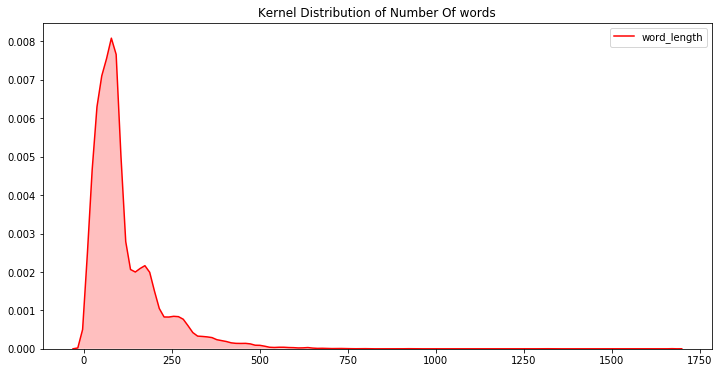

In [47]:
from matplotlib import pyplot as plt
import seaborn as sns
articles_nonEmpty['word_length'] = articles_nonEmpty['text'].apply(lambda x: len(str(x).split())) 
print(articles_nonEmpty.describe())
articles_word_limit = articles_nonEmpty[articles_nonEmpty['word_length'] > 60]
print(len(articles_nonEmpty))
print(len(articles_word_limit))
plt.figure(figsize=(12,6)) 
p1=sns.kdeplot(articles_nonEmpty['word_length'], shade=True, color="r")\
    .set_title('Kernel Distribution of Number Of words')